In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import matplotlib.pyplot as plt
from importlib import reload
import functools
%matplotlib inline

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import street_network_functions as snf
import utilities as uf
import simplify as sf
import warnings
warnings.filterwarnings('ignore')

C:\Users\g_filo01\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
reload(snf)
reload(uf)
reload(sf)

<module 'simplify' from 'C:\\Users\\g_filo01\\sciebo\\scripts\\Simplify\\simplify.py'>

In [100]:
#initialise paths, names, etc.

city_name = 'London'
tmp_ouptut = 'Outputs/'+city_name+'/'+city_name
loading_path_nodes = ('C:/Users/g_filo01/sciebo/scripts/Image of the City/Outputs/'
                      +city_name+'/large_network/'+city_name+'_nodes.shp')
loading_path_edges = ('C:/Users/g_filo01/sciebo/Scripts/GPS Trajectories/Outputs/'+
                      city_name+'/counts/'+city_name+'_edges_largeNetwork_counts.shp')
epsg = 27700
crs = {'init': 'epsg:27700', 'no_defs': True}

In [101]:
# loading original files
nodes_or = gpd.read_file(loading_path_nodes)
edges_or = gpd.read_file(loading_path_edges)

## Clipping or entire area?

In [104]:
# do you want to clip the area before simplifying 
clipping = True
path_polygon = 'C:/Users/g_filo01/sciebo/GIS Data/London/Congestion_area_polygon/Polygon.shp'

if clipping == True:
    if path_polygon != None: 
        polygon_clip = gpd.read_file(directory_polygon)
        buffer = polygon_clip.geometry.loc[0].buffer(800)
    else:
        # define the distance from the center of the UA within which you want to clip the data
        distance_from_center = 2000
        buffer = nodes.unary_union.envelope.centroid(distance)
    nodes = nodes_or[nodes_or.geometry.within(buffer)]
    edges = edges_or[edges_or.geometry.within(buffer)]
else: # entire area
    nodes, edges = nodes_or, edges_or

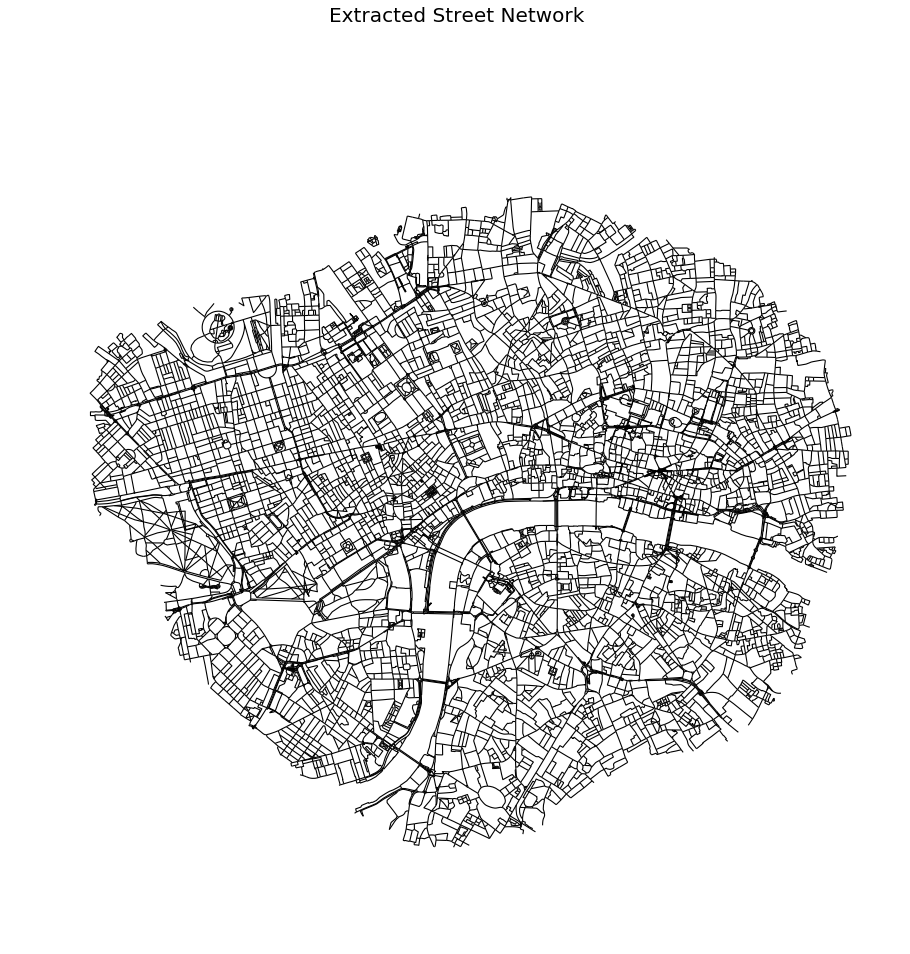

In [105]:
uf.plot_lines(edges, bb = False, f = 15, title = 'Extracted Street Network')

## Checking the network and cleaning it

In [106]:
nodes, edges = snf.clean_network(nodes, edges, detect_islands = True, dead_ends = True)
nodes_cleaned, edges_cleaned = nodes.copy(), edges.copy()

possible double edges 0
possible double edges 23
possible double edges 7
possible double edges 1
possible double edges 2
Correcting edges coordinates..
Done
Done after  5  cycles


In [108]:
# do you want to save the clipped version in its original configuration?
saving_clipped = True
if saving_clipped == True:
    saving_path ='C:/Users/g_filo01/sciebo/scripts/Image of the City/Outputs/'+city_name+'/intermediate/'+city_name
 
    # dual graph and scaling
    nodesDual_cleaned, edgesDual_cleaned = snf.dual_gdf(nodes_cleaned, edges_cleaned, crs)
    edges_cleaned['pedestrian'] *=1
    edges_cleaned.length = edges_cleaned.geometry.length
    edges_cleaned.drop('length_sc', axis = 1, inplace = True)

    col = ['Eb', 'Ab', 'length']
    for i in col: uf.scaling_columnDF(edges_cleaned, i, inverse = False)
    colDual = ['rad', 'deg']
    for i in colDual: uf.scaling_columnDF(edgesDual_cleaned, i, inverse = False)

    col = ['Bc_E', 'Bc_Rw', 'Rc400', 'Rc600', 'Bc_E_400', 'Bc_E_600', 'Bc_Rw_400', 'Bc_Rw_600']
    for i in col: uf.scaling_columnDF(nodes_cleaned, i, inverse = False)
    
    # converting lists
    to_convert = ['loc_land', 'loc_scor', 'dist_land', 'dist_scor', 'anchors', 'distances']
    nodes_cleaned_string = nodes_cleaned.copy()
    for column in to_convert: nodes_cleaned_string[column] = nodes_cleaned_string[column].astype(str)

    nodes_cleaned_string.to_file(saving_path+'_nodes.shp', driver='ESRI Shapefile')
    edges_cleaned.to_file(saving_path+'_edges.shp', driver='ESRI Shapefile')
    nodesDual_cleaned.drop('intersecting', axis = 1).to_file(saving_path+'_nodesDual.shp', driver='ESRI Shapefile')
    edgesDual_cleaned.to_file(saving_path+'_edgesDual.shp', driver='ESRI Shapefile')

# Simplification
## simplifying junctions

In [8]:
nodes, edges = nodes_cleaned.copy(), edges_cleaned.copy()
nodes, edges = sf.simplify_dual_lines_junctions(nodes, edges, update_counts = True)
nodes, edges = sf.simplify_complex_junctions(nodes, edges, update_counts = True)

Simplifying intersections: first part -------------------------- 
Correcting edges coordinates..
Done
possible double edges 0
possible double edges 8
Correcting edges coordinates..
Done
Done after  2  cycles
Simplifying intersections: second part -------------------------- Triangle-Like-Junctions
Correcting edges coordinates..
Done
possible double edges 1
possible double edges 30
possible double edges 3
Correcting edges coordinates..
Done
Done after  3  cycles


## Extracting centroids from complex junctions
### e.g. roundabouts --> cluster of nodes

In [9]:
nodes_correct, edges_correct = nodes.copy(), edges.copy()
nodes, edges = nodes_correct.copy(), edges_correct.copy()
nodes, edges, cluster, buffers = sf.extract_centroids(nodes, edges, radius = 7)

## Simplyfing dual lines

In [10]:
nodes, edges, clusters = sf.simplify_dual_lines(nodes, edges, clusters, update_counts = True)

Simplifying dual lines: First part - clusters
3692 5915 OPTION 2 - SECTION 3
38934 38938 OPTION 2 - SECTION 1
36682 64068 OPTION 2 - SECTION 2
18763 36667 OPTION 2 - SECTION 1
22047 36941 OPTION 2 - SECTION 1
27230 65038 OPTION 2 - SECTION 1
36279 36310 OPTION 2 - SECTION 1
10508 16482 OPTION 2 - SECTION 1
16490 16546 OPTION 2 - SECTION 1
42910 70430 OPTION 2 - SECTION 1
16491 16548 OPTION 2 - SECTION 1
52917 62241 OPTION 2 - SECTION 1
52940 52996 OPTION 2 - SECTION 1
41692 43311 OPTION 2 - SECTION 1
43312 52104 OPTION 2 - SECTION 1
42912 70435 OPTION 2 - SECTION 1
70617 74905 OPTION 2 - SECTION 1
42102 46213 OPTION 2 - SECTION 2
8981 24673 OPTION 2 - SECTION 1
36254 36257 OPTION 2 - SECTION 2
27529 27534 OPTION 2 - SECTION 1
27533 39540 OPTION 2 - SECTION 1
46650 46654 OPTION 2 - SECTION 1
14051 69473 OPTION 2 - SECTION 1
282 10514 OPTION 2 - SECTION 1
21193 43798 OPTION 2 - SECTION 2
47063 75715 not COMPLETED: OPTION 2 - SECTION 1
74908 75715 OPTION 2 - SECTION 1
281 4797 not COMPLET

35717 74372 OPTION 2 - SECTION 1
1449 1462 OPTION 2 - SECTION 1
24093 50693 OPTION 2 - SECTION 1
36209 49132 OPTION 2 - SECTION 1
1951 37050 OPTION 2 - SECTION 1
2030 2033 OPTION 2 - SECTION 1
33944 67750 OPTION 2 - SECTION 1
33945 37244 OPTION 2 - SECTION 1
2032 35582 OPTION 2 - SECTION 2
7939 16787 OPTION 2 - SECTION 2
7982 16788 OPTION 2 - SECTION 1
20624 46566 OPTION 2 - SECTION 1
20665 20688 27191 OPTION 3 - SECTION 2
53131 66498 OPTION 2 - SECTION 3
65907 70792 76961 OPTION 3 - SECTION 2
13204 13214 OPTION 2 - SECTION 1
4340 22830 OPTION 2 - SECTION 1
59720 60642 not COMPLETED: OPTION 2 - SECTION 1
59720 60642 not COMPLETED: OPTION 2 - SECTION 1
5514 22129 OPTION 2 - SECTION 1
31069 71749 OPTION 2 - SECTION 1
64324 65904 OPTION 2 - SECTION 1
65674 65682 OPTION 2 - SECTION 2
3561 3582 OPTION 2 - SECTION 1
31076 31078 OPTION 2 - SECTION 1
49147 63016 OPTION 2 - SECTION 1
20365 33941 OPTION 2 - SECTION 1
67757 74733 OPTION 2 - SECTION 1
35248 79798 OPTION 2 - SECTION 1
16663 79998 O

11159 28789 OPTION 2 - SECTION 1
57584 57631 OPTION 2 - SECTION 2
1090 18313 OPTION 2 - SECTION 2
18309 18333 OPTION 2 - SECTION 1
2489 57538 OPTION 2 - SECTION 1
7407 7432 not COMPLETED: OPTION 2 - SECTION 1
7408 7432 not COMPLETED: OPTION 2 - SECTION 1
7407 7408 7432 OPTION 3 - SECTION 1
8512 21347 OPTION 2 - SECTION 2
10870 17930 57897 OPTION 3 - SECTION 2
32233 32239 OPTION 2 - SECTION 1
56134 58085 OPTION 2 - SECTION 2
6578 26838 OPTION 2 - SECTION 3
6574 6580 OPTION 2 - SECTION 1
23896 27120 OPTION 2 - SECTION 2
31796 57498 not COMPLETED: OPTION 2 - SECTION 1
31796 57498 not COMPLETED: OPTION 2 - SECTION 1
7578 22512 OPTION 2 - SECTION 1
7579 69389 OPTION 2 - SECTION 1
36116 36135 OPTION 2 - SECTION 1
494 34064 OPTION 2 - SECTION 1
393 411 OPTION 2 - SECTION 1
7724 7751 OPTION 2 - SECTION 1
361 1247 OPTION 2 - SECTION 2
373 1238 2952 39654 OPTION 4
36163 45448 OPTION 2 - SECTION 2
18281 57779 OPTION 2 - SECTION 1
39604 66389 OPTION 2 - SECTION 1
10420 31774 OPTION 2 - SECTION 2
2

4162 20527 not COMPLETED: OPTION 2 - SECTION 1
4663 24540 44595 OPTION 3 - SECTION 2
34593 36305 OPTION 2 - SECTION 1
4835 17975 not COMPLETED: OPTION 2 - SECTION 3
4835 17975 not COMPLETED: OPTION 2 - SECTION 3
17202 28961 46755 OPTION 3 - SECTION 1
21750 27907 72433 OPTION 3 - SECTION 1
45095 45490 OPTION 2 - SECTION 1
21751 72389 OPTION 2 - SECTION 1
45243 45537 OPTION 2 - SECTION 1
10501 10504 44934 OPTION 3 - SECTION 3
Assigning centroids coordinates
Correcting edges coordinates..
Done
possible double edges 135
possible double edges 16
Correcting edges coordinates..
Done
Done after  2  cycles
Done


In [11]:
nodes_simp, edges_simp = sf.simplify_dual_linesNodes(nodes, edges, clusters, update_counts = True)

Simplifying dual lines: Second part - nodes
516 518 sub1 NODE node  196 cluster  38786
2116 2117 sub1 NODE node  793 cluster  39546
2231 2232 sub1 NODE node  829 cluster  39569
2494 2498 sub1 NODE node  916 cluster  35862
3816 3817 sub1 NODE node  1402 cluster  39175
3843 3844 sub1 NODE node  1411 cluster  33341
4360 4361 sub1 NODE node  1611 cluster  39175
4852 4855 sub1 NODE node  1791 cluster  37788
4851 4867 sub1 NODE node  1797 cluster  37788
4965 4980 sub1 NODE node  1838 cluster  36970
5007 5009 sub2 NODE node  1848 cluster  38962
5085 5086 sub1 NODE node  1874 cluster  35319
5196 5199 sub1 NODE node  1914 cluster  38914
5506 5507 sub1 NODE node  2030 cluster  39569
1840 6636 sub1 NODE node  2435 cluster  39363
7499 7500 sub1 NODE node  2744 cluster  34124
8314 8315 sub1 NODE node  3043 cluster  33375
8925 8926 sub1 NODE node  3267 cluster  32872
10156 10157 sub1 NODE node  3714 cluster  35736
10201 10202 sub1 NODE node  3734 cluster  34365
9230 11240 sub2 NODE node  4117 cluste

2258 56638 sub1 NODE node  32587 cluster  39207
1125 87754 sub1 NODE node  32623 cluster  35270
62080 87271 sub1 NODE node  32627 cluster  37343
42149 74067 sub1 NODE node  32632 cluster  34396
23329 41402 sub1 NODE node  32656 cluster  38022
32388 32417 sub1 NODE node  32720 cluster  36690
18763 37038 sub2 NODE node  32973 cluster  32985
36254 36265 sub3 NODE node  33212 cluster  33778
12973 68377 sub2 NODE node  33599 cluster  33786
39081 39116 sub1 NODE node  34541 cluster  34524
45159 45162 sub1 NODE node  34837 cluster  34857
18971 18975 sub3 NODE node  35357 cluster  35289
15057 28315 sub3 NODE node  35428 cluster  35305
37350 49119 sub2 NODE node  35428 cluster  35270
15505 27754 sub3 NODE node  35481 cluster  34671
13205 13224 sub3 NODE node  35730 cluster  35676
43181 49380 sub1 NODE node  36055 cluster  36063
20911 43966 sub3 NODE node  36172 cluster  36416
22204 72396 sub1 NODE node  36612 cluster  36391
55370 72115 sub2 NODE node  36823 cluster  36799
124 32204 sub2 NODE no

## Resimplifying complex junctions

In [12]:
nodes, edges = nodes_simp.copy(), edges_simp.copy()
nodes, edges = sf.simplify_dual_lines_junctions(nodes, edges, update_counts = True)
nodes, edges = sf.simplify_complex_junctions(nodes, edges, update_counts = True)

Simplifying intersections: first part -------------------------- 
Correcting edges coordinates..
Done
possible double edges 0
possible double edges 2
Correcting edges coordinates..
Done
Done after  2  cycles
Simplifying intersections: second part -------------------------- Triangle-Like-Junctions
Correcting edges coordinates..
Done
possible double edges 0
possible double edges 5
Correcting edges coordinates..
Done
Done after  2  cycles


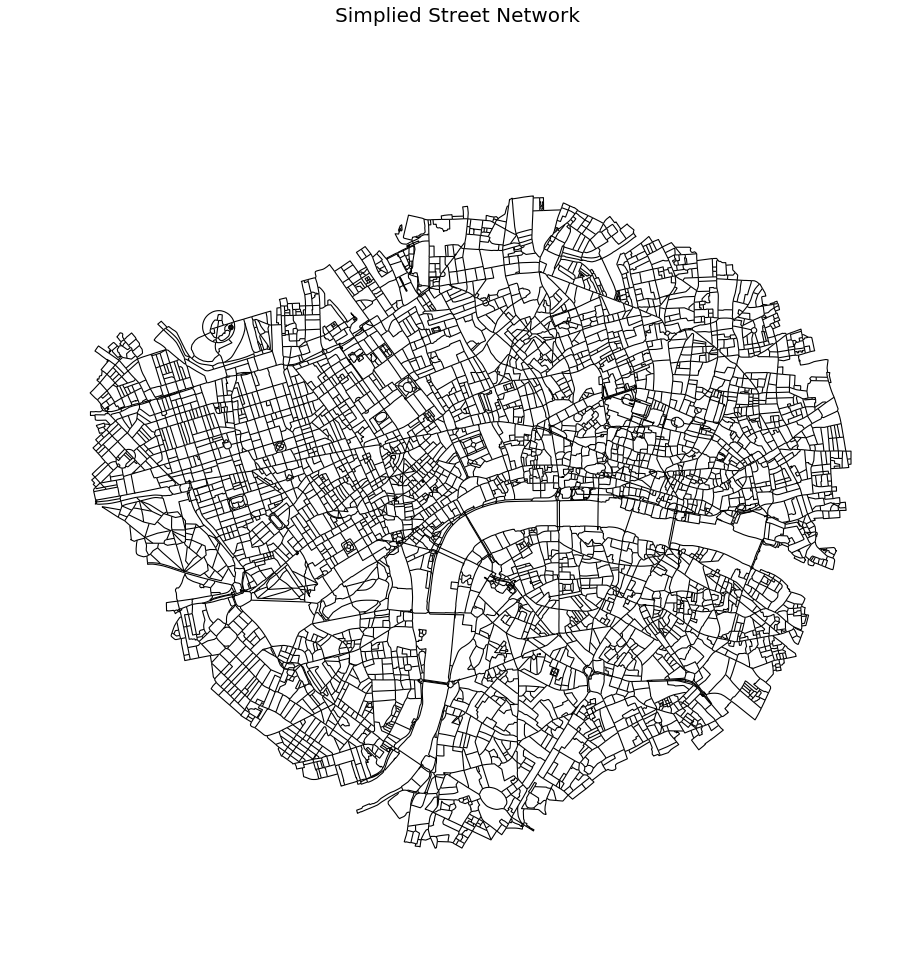

In [29]:
uf.plot_lines(edges, bb = False, f = 15, title = 'Simplied Street Network')

In [ ]:
nodes_backup, edges_backup = nodes.copy(), edges.copy()

## Assigning visibility/ centrality mesaures to new nodes

In [21]:
nodes, edges = nodes_backup.copy(), edges_backup.copy()
nodes = sf.assign_vis(nodes, nodes_cleaned)

at row: 40511

In [23]:
file = IoC_output+"_visibility_matrix.csv"
vm = pd.read_csv(file)
vm.drop('Unnamed: 0', axis = 1 , inplace = True)
vm.head()

,Unnamed: 0,buildingID,0,1,4,8,10,12,13,15,...,32014,32015,32016,32018,32026,32027,32032,32033,32034,32036
0,0,34770,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,34772,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,34777,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,34774,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,34778,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
nodeIDs = list(nodes.nodeID)
nodeIDs_original = list(nodes_cleaned.nodeID)
missing = [item for item in nodeIDs if item not in nodeIDs_original]
for i in missing: vm[str(i)] = 0
    
index_old = nodes.columns.get_loc("oldIDs")+1 

for row in nodes.itertuples():
    if not row[0] in missing: continue
    oldIDs = row[index_old]
    
    for i in oldIDs:
        tmp = vm[vm[str(i)] == 1]
        if len(tmp) < 1: continue
        to_change = list(tmp.buildingID)
        vm[str(row[0])][vm['buildingID'].isin(to_change)] = 1

In [31]:
to_keep = [str(i) for i in list(nodes.nodeID)]
to_keep = ['buildingID'] + to_keep
vm = vm[to_keep]
vm.head()

,buildingID,1,8,10,12,13,15,22,26,27,...,40502,40503,40504,40505,40506,40507,40508,40509,40510,40511
0,34770,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34772,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34777,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34774,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,34778,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
# dual graph and scaling
nodesDual, edgesDual = snf.dual_gdf(nodes, edges, crs)
edges['pedestrian'] *=1
edges.length = edges.geometry.length
edges.drop('length_sc', axis = 1, inplace = True)

col = ['Eb', 'Ab', 'length']
for i in col: uf.scaling_columnDF(edges, i, inverse = False)
colDual = ['rad', 'deg']
for i in colDual: uf.scaling_columnDF(edgesDual, i, inverse = False)

In [ ]:
col = ['Bc_E', 'Bc_Rw', 'Rc400', 'Rc600', 'Bc_E_400', 'Bc_E_600', 'Bc_Rw_400', 'Bc_Rw_600']
nodes = sf.assign_centrality(nodes, nodes_or, col)
for i in col: uf.scaling_columnDF(nodes, i, inverse = False)

In [93]:
saving_path ='C:/Users/g_filo01/sciebo/scripts/Image of the City/Outputs/'+city_name+'/intermediate/'+city_name

to_convert = ['loc_land', 'loc_scor', 'dist_land', 'dist_scor', 'anchors', 'distances', 'oldIDs']
nodes_string = nodes.copy()
for column in to_convert: nodes_string[column] = nodes_string[column].astype(str)
    
nodes_string.to_file(saving_path+'_nodes_simplified.shp', driver='ESRI Shapefile')
edges.to_file(saving_path+'_edges_simplified.shp', driver='ESRI Shapefile')
nodesDual.drop('intersecting', axis = 1).to_file(saving_path+'_nodesDual_simplified.shp', driver='ESRI Shapefile')
edgesDual.to_file(saving_path+'_edgesDual_simplified.shp', driver='ESRI Shapefile')
vm.to_csv(saving_path+'_visibility_matrix_simplified.csv')